Lets play some games with maximum depositional ages (MDAs). 

This notebook is intended to work through some excersizes with MDAs to highlight how often we should expect to observe the youngest grains in a detrital population. This includes both some analytical treatments and some monte-carlo simulations.

In [1]:
#Import some functions that will help us out
#To ensure those plots get slotted into the notebook
%matplotlib notebook 
from matplotlib import pyplot as plt #For basic plotting
from matplotlib import cm

import numpy as np #For dealing with numbers and arrays

In [2]:
#First up, I am going to define some functions that will be helpful later on,
#You MUST run this cell, but you don't have to read into it all in detail

def MDA_simpleOverlap(ages,errors,xSigmaOverlap = 2,n = 3,excludeExtraOverlap = False):
    '''
    Identify the youngest suit of ages that overlap within the specified error
    :param ages: The mean values
    :param errors: The error ranges where uncertainty is tolerated
    :param xSigmaOverlap: With in how many standard deviations of the uncertainty to we want to look for overlap?
    :param n: The minimum number of grains that are required to overlap
    :param excludeExtraOverlap: boolean, do you only want the n youngest overlapping grains (True), or will you take at least n (False)?
    :return:
    '''

    #First sort the grains from youngest to oldest
    agesSrtd, errorsSrtd = sortAgesErrors(ages,errors)
    errorsSrtd*=xSigmaOverlap

    minMax = np.zeros((len(ages),2)) #Initialize an array with two colums, one for the min one for max of each grain

    #Populate with the range
    minMax[:,0] = agesSrtd - errorsSrtd
    minMax[:,1] = agesSrtd + errorsSrtd

    #Did we find a result?
    foundResult = False

    #Look through the sorted ranges from youngest to oldest, there is also a recursive approach to this. Starting
    #from each point in the sorted array search your neighbors, if they are within bounds search their neighbors, just have
    #to be careful with that - because one sample may have a higher mean but broader spread, causing it to sit farther away
    #in the array but stilloverlap
    for i in range(len(ages)):
        thisMinMax = minMax[i]

        #How many places is this upper bound within other ranges
        upperInBounds = (thisMinMax[1] >= minMax[:,0]) & (thisMinMax[1] <= minMax[:,1])

        #How many places is this upper bound within other ranges
        lowerInBounds = (thisMinMax[0] >= minMax[:,0]) & (thisMinMax[0] <= minMax[:,1])

        #How many total matches
        totalMatches = upperInBounds | lowerInBounds
        nMatches = np.sum(totalMatches)
        #If we found enough matching grains, quit
        if nMatches >= n:
            foundResult = True

            # If we found too many overlapping grains, just take the first n
            if (nMatches > n) & excludeExtraOverlap:
                matchAges = agesSrtd[totalMatches][:n]
                matchErrors = errorsSrtd[totalMatches][:n]
            else:
                matchAges = agesSrtd[totalMatches]
                matchErrors = errorsSrtd[totalMatches]
            break

    #If we found a result calculate a weighted mean, if not return nan
    if foundResult:
        mean,error = weightedMean(matchAges,matchErrors)
        mswd = np.sum((mean - matchAges)**2/matchErrors**2)/(len(matchAges) - 1)
    else:
        mean, error = np.nan, np.nan
        mswd = np.nan
    return mean,error,mswd

def sortAgesErrors(ages,errors):
    '''
    Return a sorted copy of the ages and errors
    :param ages:
    :param errors:
    :return:
    '''

    #First sort the grains from youngest to oldest
    srtIdx = np.argsort(ages)
    agesSrtd = ages[srtIdx]
    errorsSrtd = errors[srtIdx]

    return agesSrtd, errorsSrtd

def weightedMean(ages,errors):
    '''
    Calculate a weighted mean age
    :param ages:
    :param errors:
    :return:
    '''

    weights = 1.0/(errors**2)

    meanAge = np.sum(weights * ages) / np.sum(weights)

    meanError = 1.0 / np.sqrt(np.sum(weights))

    return meanAge,meanError

def plotAgesErrors(ages,errors,minY = 0.0, maxY = 1.0,**kwargs):
    '''
    Create a plot of ages and arrays ( a cal tech style plot), with
    ages spaced evenly vertically between a min and max
    :param ages: numpy array of ages
    :param errors: numpy array of errors
    :param minY: minimum Y value to plot an age on
    :param maxY: maximum Y value to plot an age on
    :param kwargs:

    :return:
    '''
    srtdAges,srtdErrors = sortAgesErrors(ages,errors)
    yVals = np.linspace(minY,maxY,len(ages))

    plt.errorbar(srtdAges,yVals,yerr=None,xerr=srtdErrors,fmt='o',**kwargs)

def calcGaussKDE(ages,ageAxis,bandwidth):
    '''
    Calculate the KDE for the dates in ages over the axis, age axis, with a gaussian kernel with the specified
    bandwidth
    :param ages: a numpy array of ages
    :param ageAxis: the x axis of ages we want to calculate the KDE probabilities on
    :param bandwidth: the gaussian kernel bandwidth for the KDE
    :return:
    '''

    Kernel = lambda t: (1 / np.sqrt(2.0 * np.pi)) * np.exp((-t ** 2) / 2)

    KDE = np.zeros_like(ageAxis)

    # Iterate through the ages
    for age in ages:
        KDE += Kernel((ageAxis - age) / bandwidth)

    KDE /= len(ages)*bandwidth
    return KDE



In [3]:
#Lets make up some ages, just to highlight an example
ages = np.array([40.3,47.0, 50.0, 60.0, 55.0, 75.0, 87.0, 85.0, 75.0, 56.0, 57.0])
errors = ages*0.025 #For simplicity lets say that there is just a constant percent error on measurements

#Now lets identify the MDA as the youngest suite of overlapping grains of some size
numberOfYoungestOverlappingGrains = 3 #How many grains have to overlap to call it an MDA?

#Find the weighted mean age and error. To do this, we start from the youngeset grain and search through the 
#other grains to find overlapping samples. If there are enough matches we quit, if not we search out the next youngest
#grain
weightedMeanMDA,weightedErrorMDA,_ = MDA_simpleOverlap(ages,errors,n = numberOfYoungestOverlappingGrains) 

#Write that output
print('Weighted mean age, error: {0:.1f}, {1:.1f}'.format(weightedMeanMDA,weightedErrorMDA)) #What is the weighted mean age and error of the youngest grain

Weighted mean age, error: 50.2, 1.5


<IPython.core.display.Javascript object>


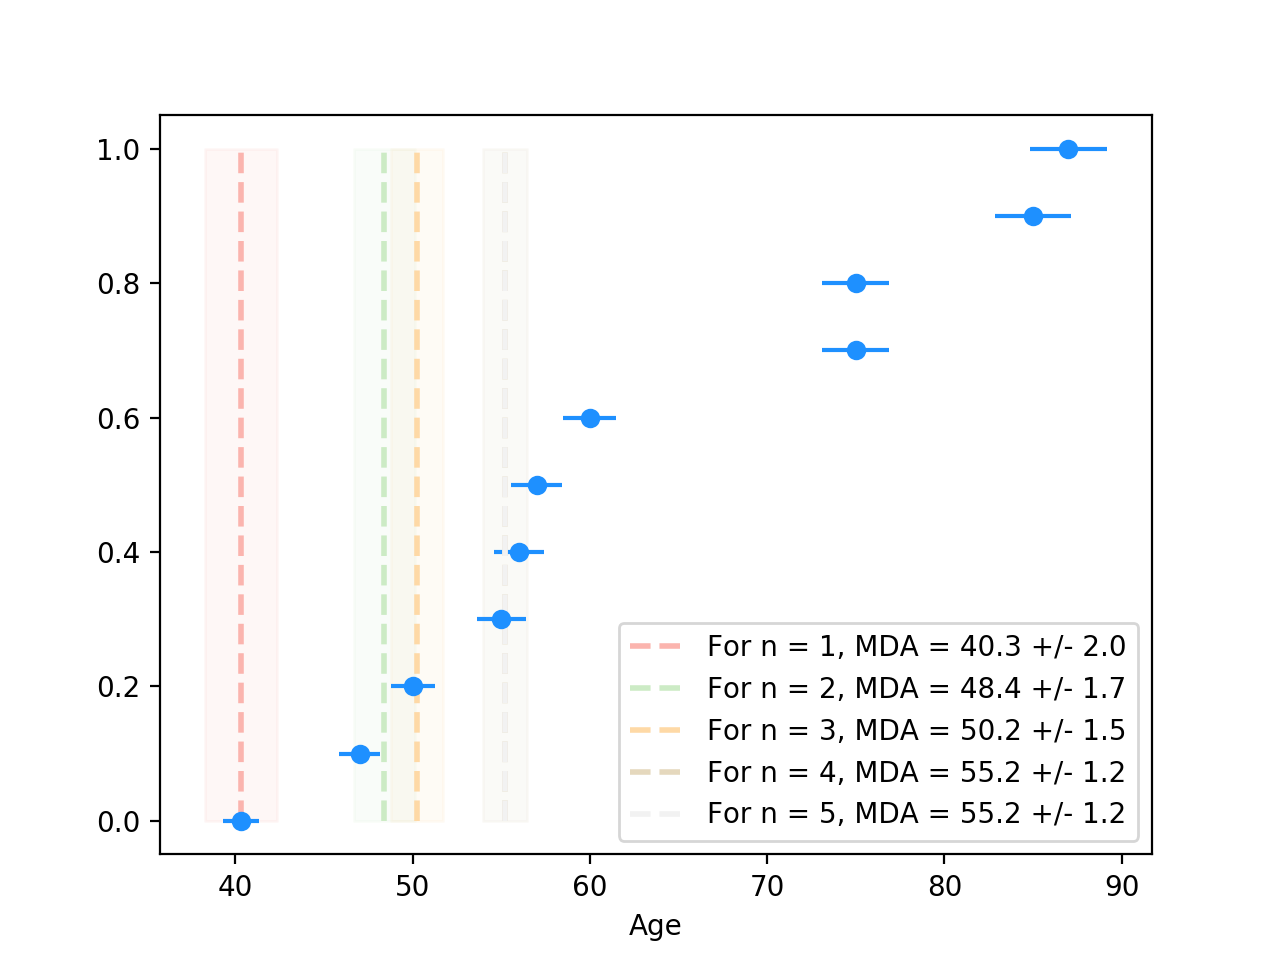

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in double_scalars


Text(0.5,0,'Age')

In [4]:
#What would this look like for different requirements for the number of overlapping grains?

#First lets just plot the ages and errors
plotAgesErrors(ages,errors,minY = 0.0, maxY = 1.0,color = 'dodgerblue')

#Now lets loop through a few different values of 'n' used to define our MDA
nsToCalc = range(1,6) #Which ns to use
cmap = cm.get_cmap('Pastel1') #Get a colormap for plotting thse results
colors = [cmap(i) for i in np.linspace(0,1,len(nsToCalc))]

#Get this n value and its color in a loop
for n,color in zip(nsToCalc,colors):
    #Calculate these values
    wmMDA,werr,_ = MDA_simpleOverlap(ages,errors,n = n) 
    
    #Add this to the plot as a vertical bar
    plt.plot([wmMDA,wmMDA], [0,1],'--',color = color,linewidth = 2,label = 'For n = {:d}, MDA = {:.1f} +/- {:.1f}'.format(n,wmMDA,werr))
    plt.fill_between([wmMDA - werr, wmMDA+werr],[0,0],[1,1],color = color, alpha = 0.10)
    
plt.legend(loc = 'best')
plt.xlabel('Age')

Notice how the MDA increases as we increase the number of grains required to define it? This will be true for any single set of data. The rate at which the MDA grows with n will depend on the properties of that distribution. Clusters of young grains will tend to slow the growth of the MDA as a function of n. To illustrate MDA behavior further, lets create an interactive example. The following will allow you to click to create some dynamic data and update MDAs along the way.

<IPython.core.display.Javascript object>


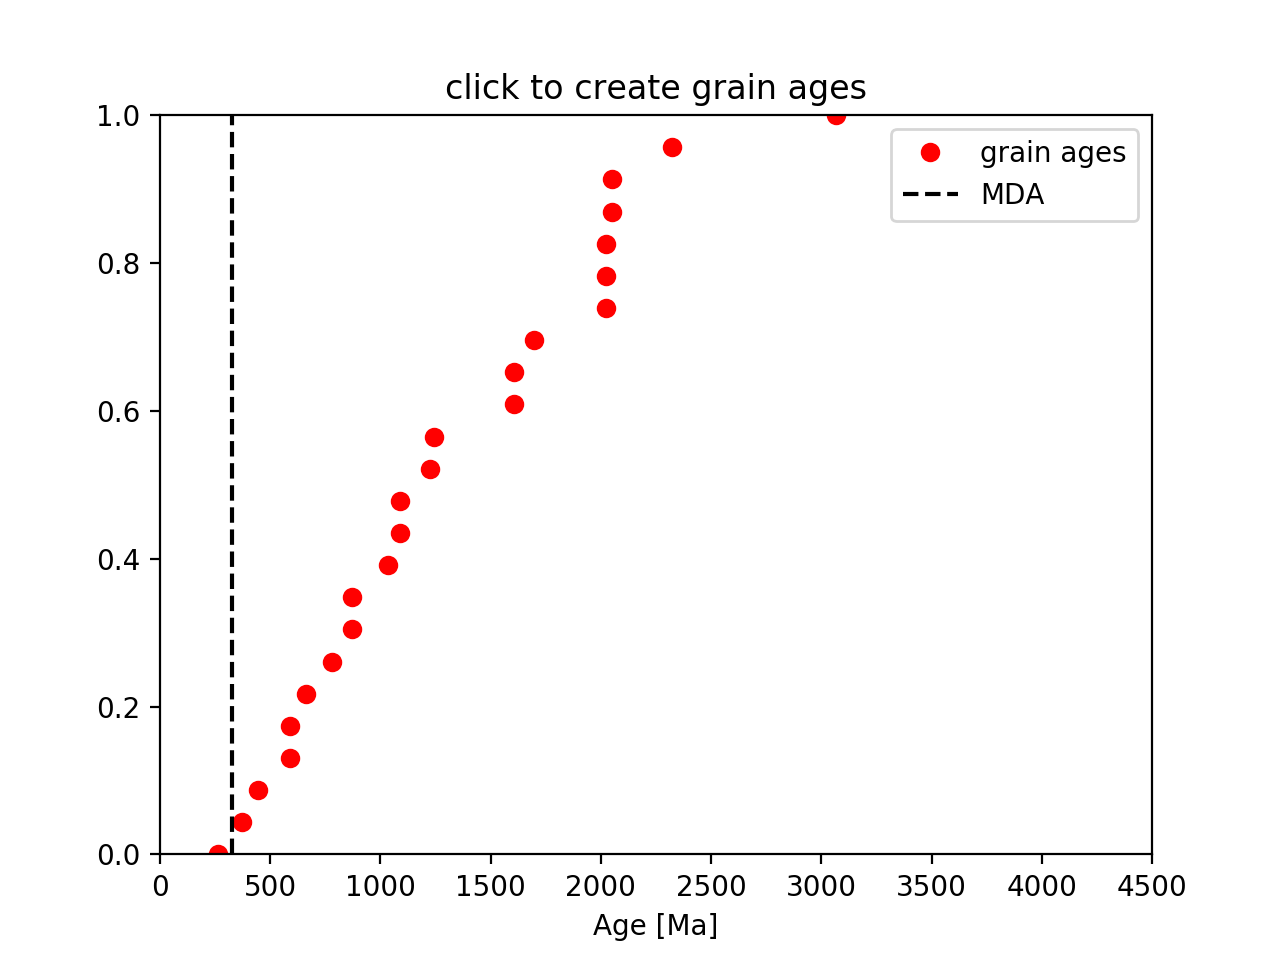

In [5]:
#First we will import some functions that help us interact with graphs
import plotInteractionFuncs as PIF


#Create a figure
fig = plt.figure()
#Add an axis to that figure
ax = fig.add_subplot(111)

#Set the x limits of that axis to the age of the earth
ax.set_xlim(0,4500)

#Create to lines, one will represent our 'data' - the interactive plot will populate this
dataline, = ax.plot([],[],'or',label = 'grain ages')

#The second line will represent the MDA (with no ages yet calculated, we can still be pretty sure the deposit is
#younger than the age of the earth)
mdaline, = ax.plot([4500,4500],[0,1],'--k',label = 'MDA')

#Add a title to remind you to click in the box to create data
ax.set_title('click to create grain ages')
ax.set_ylim(0,1) #Set the y limits
ax.set_xlabel('Age [Ma]') #Set the x limits
plt.legend() #Add the legend

#This creates the interactive function that updates data and MDAs - it is 'listening' for your mouse clicks
#Mouse clicks get turned into age data points at the specified value
tdf = PIF.MDAExample(dataline,mdaline,relError = 0.1)

<IPython.core.display.Javascript object>


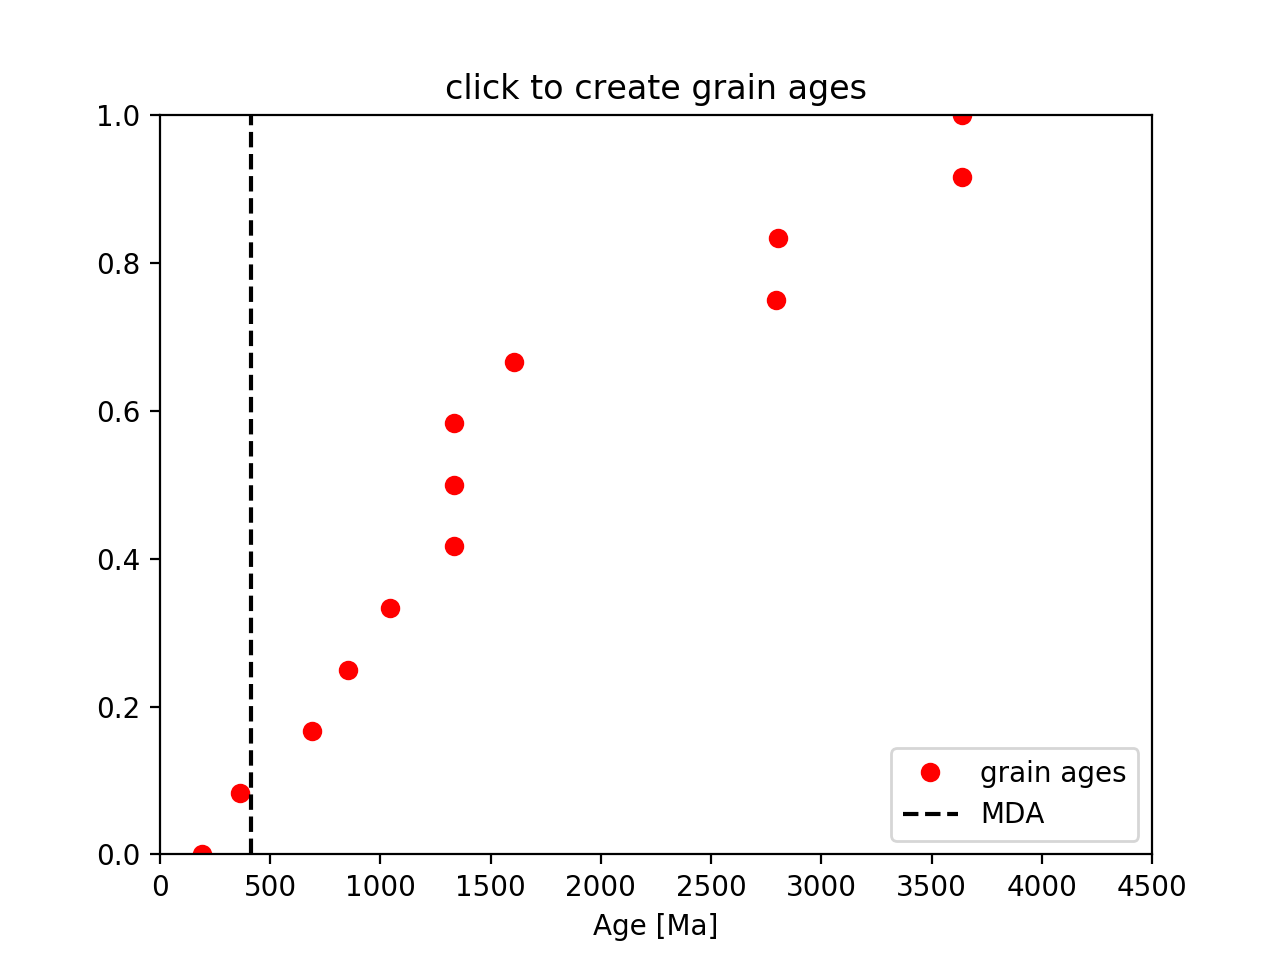

In [6]:
#Alternatively, we can try this again - but make up a different MDA function (whatever you choose)
#Again we'll go through the motions of making a figure, etc.
#Create a figure
fig = plt.figure()
#Add an axis to that figure
ax = fig.add_subplot(111)

#Set the x limits of that axis to the age of the earth
ax.set_xlim(0,4500)

#Create to lines, one will represent our 'data' - the interactive plot will populate this
dataline, = ax.plot([],[],'or',label = 'grain ages')

#The second line will represent the MDA (with no ages yet calculated, we can still be pretty sure the deposit is
#younger than the age of the earth)
mdaline, = ax.plot([4500,4500],[0,1],'--k',label = 'MDA')

#Add a title to remind you to click in the box to create data
ax.set_title('click to create grain ages')
ax.set_ylim(0,1) #Set the y limits
ax.set_xlabel('Age [Ma]') #Set the x limits
plt.legend() #Add the legend


#Now lets do something new, the MDAExample object can take an argument that is a function that calculates an MDA.

#Define a new function that takes arrays of ages and errors, this example just takes the mean
#of the youngest three samples (no need for these to overlap). Feel free to make up your own MDA function,
# by changing the code inside this function (it still needs to just take two inputs, and return the MDA)
def ourNewMDAFunc(ages,errors):
    nGrains = 3 
    
    #If there aren't enough grains, don't define an MDA
    if len(ages) >= nGrains:
        srtdAges = np.sort(ages) #Sort the grain ages
        MDA = np.mean(srtdAges[:nGrains]) #Grab the youngest n grains and take their average.
    else:
        MDA = 4500.0        
    return MDA
    

#Now, when we create the interactive object we need to pass it the MDA function we created
tdf = PIF.MDAExample(dataline,mdaline,relError = 0.1, MDAfunc = ourNewMDAFunc)

So with the previous examples hopefully we've highlighted one consequence of MDA approaches that require some agreement between multiple grains; the more overlapping grains necessary to define an MDA the older that MDA will be. 

Lets take a look at a different effect now, how likely are you to encounter the youngest age in a sample? And how many times will you encounter it? Through this we will try to show that if you encounter the youngest age in a sample many times (but are just looking at the youngest n grains), uncertainty in your ability to measure that youngest age will pull the MDA toward younger ages. 

We will do this by clicking to create a *distribution* now, instead of clicking to create individual ages

<IPython.core.display.Javascript object>


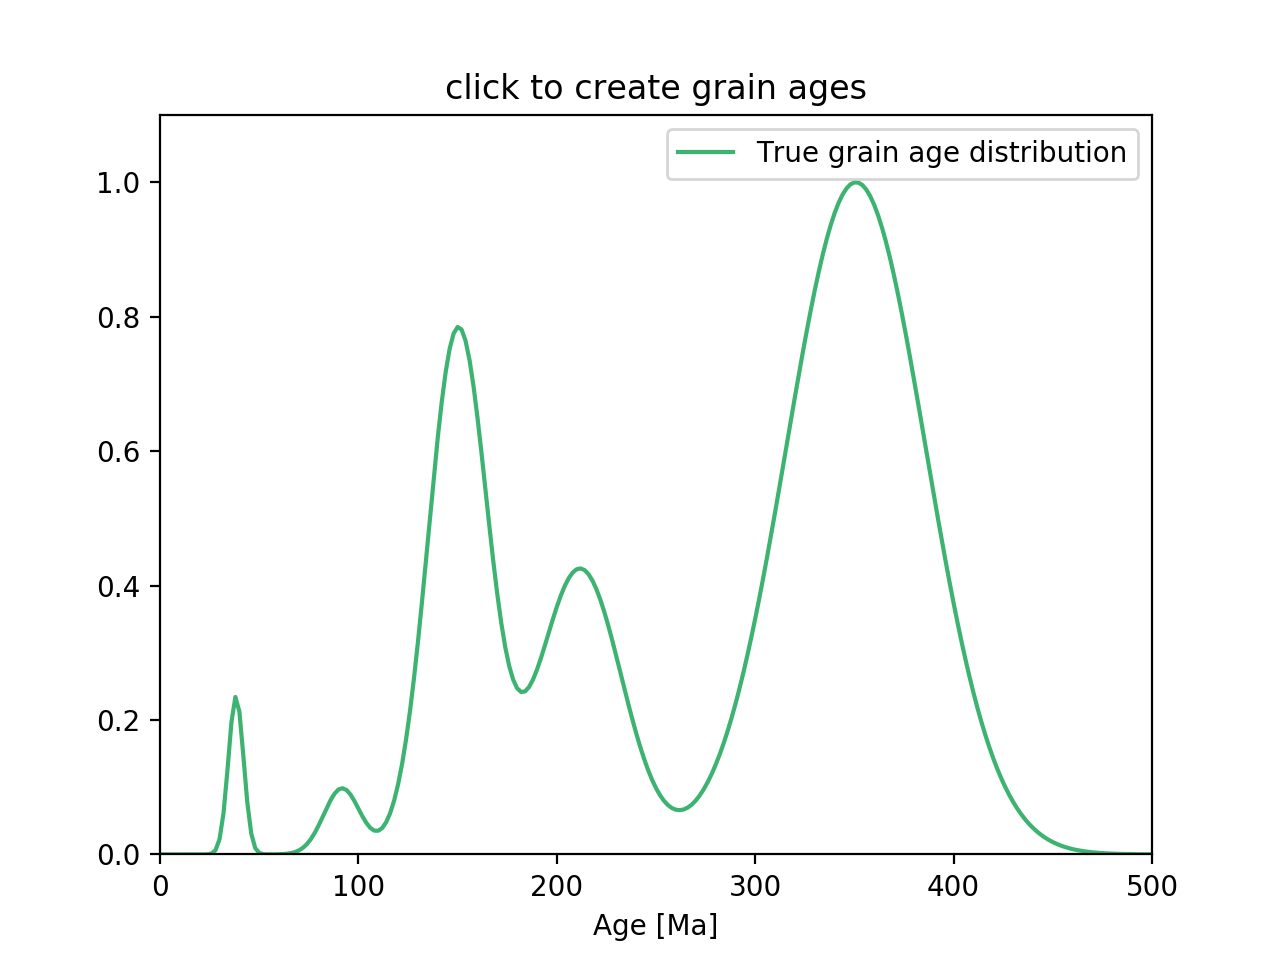

In [7]:
#Create a figure
fig = plt.figure()
#Add an axis to that figure
ax = fig.add_subplot(111)

#Define the minimum and maximum ages (can be useful to not see the whole distribution here)
minAge = 0.0
maxAge = 500.0
dAge = 2.0

#What 'error' is observed on ages?
relativeError = 0.1

#Set the x limits of that axis to the age of the earth
ax.set_xlim(minAge,maxAge)

#Create a lines
ageAxis = np.arange(0,4500.0,dAge)
dataline, = ax.plot([],[],'-',color = 'mediumseagreen',label = 'True grain age distribution')

#Add a title to remind you to click in the box to create data
ax.set_title('click to create grain ages')
#Set the y limits, the way the plot interaction is set up it will always top out at 1
ax.set_ylim(0,1.1) 
ax.set_xlabel('Age [Ma]') #Set the x limits
plt.legend() #Add the legend

#This creates the interactive function that updates data and MDAs - it is 'listening' for your mouse clicks
#Mouse clicks get turned into age data points at the specified value
tdf = PIF.distributionMaker(dataline,ageAxis,relError = relativeError)

<IPython.core.display.Javascript object>


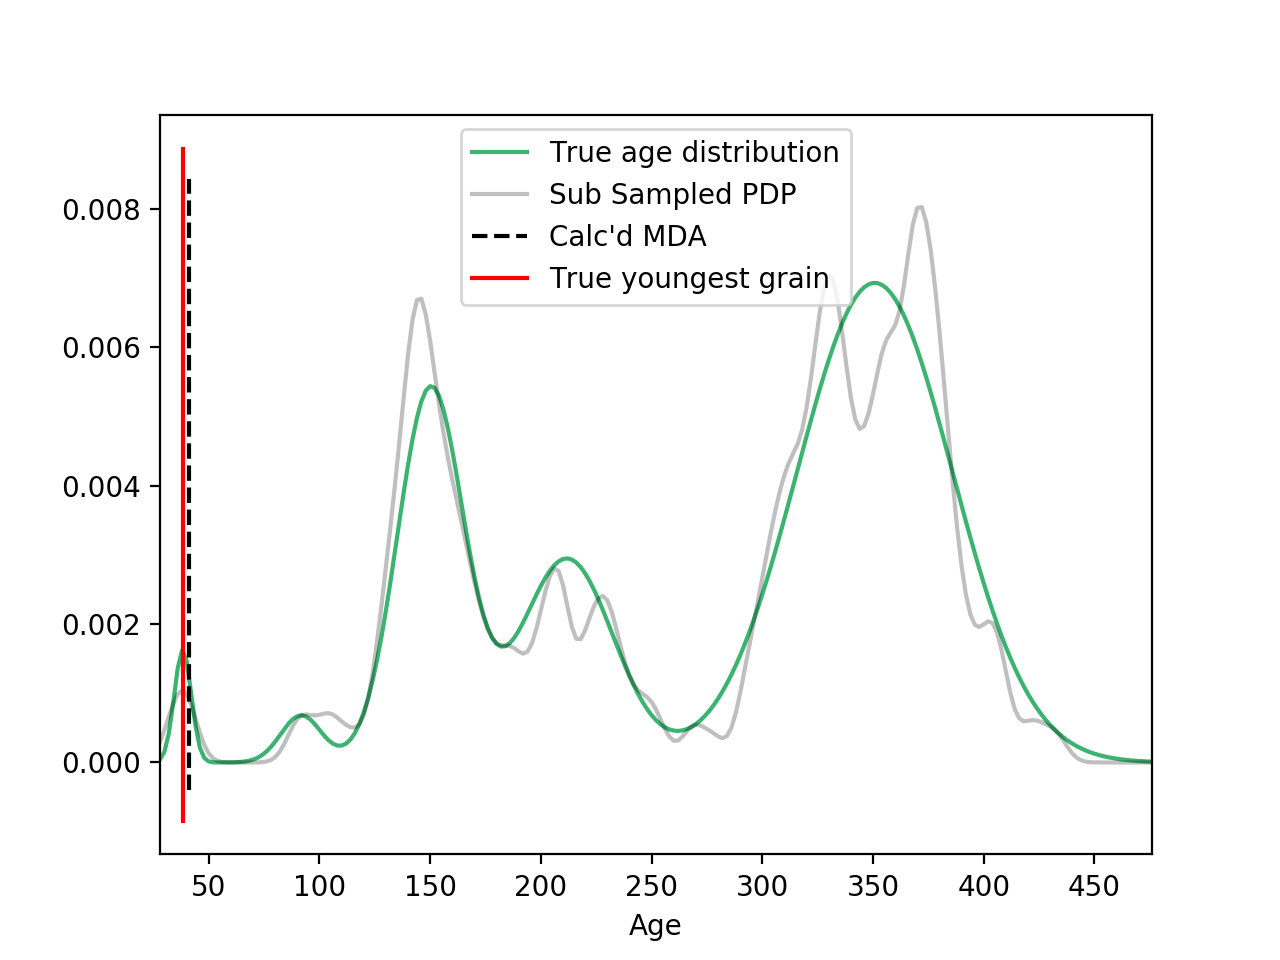

interactive(children=(IntSlider(value=250, description='NumberOfGrainsToDraw', max=500, min=25, step=25), IntSlider(value=5, description='NumberOfGrainsForMDA', max=10, min=1), Checkbox(value=True, description='ClickUnClickToUpdate'), Output()), _dom_classes=('widget-interact',))

In [10]:
#Import ipywidgets so that we can make some sliders
from ipywidgets import interactive
#Lets get the data from that PDF you just created
TrueMDA = np.min(tdf.ages)
pdp = tdf.p/np.sum(tdf.p*dAge)

#Lets create a function to draw a subset of grains, and calculate a PDF and MDA
def randSampler(NumberOfGrainsToDraw,NumberOfGrainsForMDA):
    #Sample from the age axis, with replacement, according to the PDFs probabilities
    sampledAges = np.random.choice(ageAxis,NumberOfGrainsToDraw,replace = True,p = pdp/np.sum(pdp))
    sampledErrors = sampledAges*relativeError
    
    #From these calculate the MDA
    MDA = MDA_simpleOverlap(sampledAges,sampledErrors,NumberOfGrainsForMDA)[0]
    
    #And construct a PDP - this can lead to a lack of overlap between the mean of many 'sampled' PDFs and the true PDF.
#     p = np.zeros_like(ageAxis)
#     for age, error in zip(sampledAges, sampledErrors):
#         p += (1.0 / np.sqrt(2.0 * error ** 2 * np.pi)) * np.exp(-(ageAxis - age) ** 2 / (2.0 * error ** 2))
        
    #Alternatively construct a KDE, I've fixed the bandwidth here, so this might not work great with all datasets
    p = calcGaussKDE(sampledAges,ageAxis,bandwidth = 5.0)
    
    #Return the PDF and the MDA
    return p/np.sum(p*dAge),MDA
    


def subSampleMDA(NumberOfGrainsToDraw, NumberOfGrainsForMDA,ClickUnClickToUpdate):
    
    plt.figure(1,figsize=(9.5,3))
    plt.clf()
    plt.plot(ageAxis,pdp,'-',color = 'mediumseagreen',linewidth = 1.5, label = 'True age distribution')
    p,MDA = randSampler(NumberOfGrainsToDraw,NumberOfGrainsForMDA)
    
    plt.plot(ageAxis,p,'-k',alpha = 0.25,label = 'Sub Sampled PDP')
    plt.plot([MDA,MDA],plt.ylim(),'--k',label = 'Calc\'d MDA')
    plt.plot([TrueMDA,TrueMDA],plt.ylim(),'-r',label = 'True youngest grain')
    plt.legend(loc = 'best')
    plt.xlabel('Age')
    plt.xlim(np.min(ageAxis[pdp>1e-5]),np.max(ageAxis[pdp>1e-5]))
    plt.show()

    
#This was supposed to be an interactive, but it doesn't appear to work with all versions of python/jupyter. Need to work on this.
plt.figure(1)
interactive_plot = interactive(subSampleMDA, NumberOfGrainsToDraw=(25, 500,25), NumberOfGrainsForMDA=(1,10,1),ClickUnClickToUpdate = True)
output = interactive_plot.children[-1]
interactive_plot

Thats fun and all, but lets just simulate a boatload of iterations in order to get a sense of the distribution of MDAs. Experiment with the parameters here to highlight different behaviors.

<IPython.core.display.Javascript object>


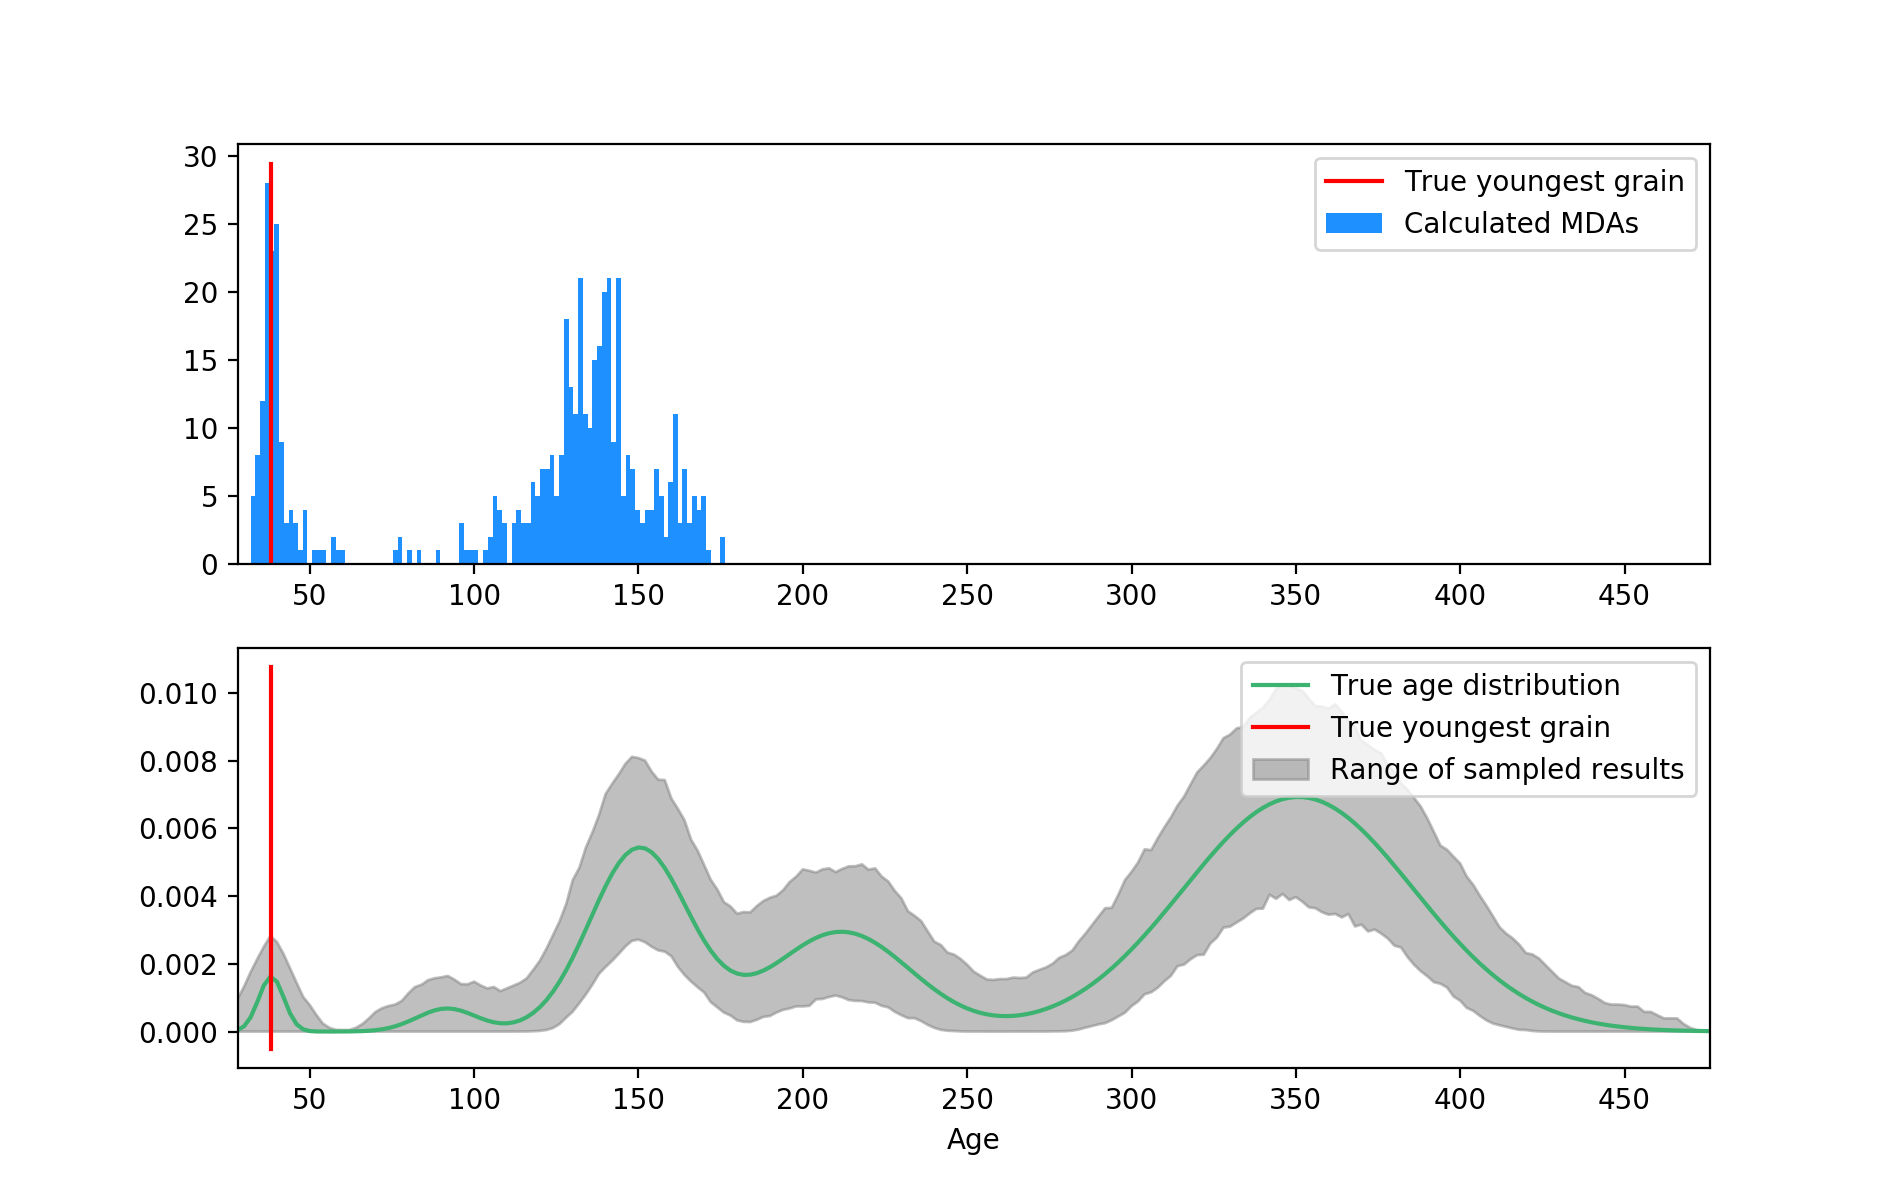

In [11]:
#How many iterations do we want to run?
'''Note that in this graph the confidence interval (the gray bounds of sampled PDFs) don't perfectly overlap
the 'true' distribution if 'randSample' (defined above) generates a PDF as a PDP. What gives? We are drawing random samples from this true distribution AND assigning error to these values,
and then calculating a PDP as the sum of individual gaussian PDFs for each age we draw. This spreads the probability out over an
too large of an area for some peaks, which then reduces their height.
'''

nIterationsToRun = 500

#Parameters for random sampling
numberOfGrainsToDraw = 100
numberOfGrainsForMDA = 3

#Preallocate some space to save all the randomly sampled PDFs and MDA
MDAs = np.zeros(nIterationsToRun)
PDFs = np.zeros((nIterationsToRun,len(ageAxis)))

#Store the outputs from these iterations
for i in range(nIterationsToRun):
    PDFs[i,:],MDAs[i]  = randSampler(numberOfGrainsToDraw,numberOfGrainsForMDA)

#Rather than plotting all the random PDFs, lets just plot the bounds of them
confInt = 0.05 #Look at 5% and 95% bounds, or whatever else this gets changed to
lowerBound = np.percentile(PDFs,100*confInt,axis = 0)
upperBound = np.percentile(PDFs,100*(1.0 - confInt),axis = 0)

#Plot the results
plt.figure(figsize=(9.5,6))
plt.subplot(2,1,2)
plt.fill_between(ageAxis,lowerBound,upperBound,color = 'grey',alpha = 0.5,label = 'Range of sampled results')
plt.plot(ageAxis,pdp,'-',color = 'mediumseagreen',linewidth = 1.5, label = 'True age distribution')
plt.plot([TrueMDA,TrueMDA],plt.ylim(),'-r',label = 'True youngest grain')
plt.legend(loc = 'best')
plt.xlabel('Age')
plt.xlim(np.min(ageAxis[pdp>1e-5]),np.max(ageAxis[pdp>1e-5]))

plt.subplot(2,1,1)
plt.hist(MDAs,bins = 100,histtype = 'stepfilled',color = 'dodgerblue',label = 'Calculated MDAs')
plt.plot([TrueMDA,TrueMDA],plt.ylim(),'-r',label = 'True youngest grain')
plt.legend(loc = 'best')
plt.xlim(np.min(ageAxis[pdp>1e-5]),np.max(ageAxis[pdp>1e-5]))
plt.show()

There are two competing effects here, the shift towards older MDAs when we consider multiple grains (and most of the distribution is old), and the shift toward young ages if we sample the young population many times. The first examples hopefully highlighted the first effect (if not try it again), this last example will look at the later. 

Specifically, what happens to our MDA as we sample more and more grains?

To do this we will draw a random sample, calculate an MDA, then continue adding grains to it to and recalculating our MDA

In [12]:
#First how many grains do we want to sample?
minGrainsToSample = 25
maxGrainsToSample = 1000
nSamplingInterval = 5
nGrainsForMDA = 3

nsToTest = np.arange(minGrainsToSample,maxGrainsToSample,nSamplingInterval)
MDAs = np.zeros_like(nsToTest)

#We need to be careful now, what we want to show is that as we keep adding grains our MDA
#will change. This is different than the case where we kept taking new,random
#samples of increasing size. Both would show the same general effect, but in the later case 
#we would expect some 'noise' just from re-sampling new distributions

#Start with the minimum number of grains
sampledAges = np.random.choice(ageAxis,minGrainsToSample,replace = True,p = pdp/np.sum(pdp))
sampledErrors = sampledAges*relativeError

MDAs[0] = MDA_simpleOverlap(sampledAges,sampledErrors,n = nGrainsForMDA)[0]

#ITerate through the different number of grains to test
for i in range(1,len(nsToTest)):
    #Select some new grains
    newGrains = np.random.choice(ageAxis,nSamplingInterval,replace = True,p = pdp/np.sum(pdp))
    
    #Add them to our existing list of grains, and recalculate all the errors
    sampledAges = np.append(sampledAges,newGrains)
    sampledErrors = sampledAges*relativeError
    
    #Calculate the MDA
    MDAs[i] = MDA_simpleOverlap(sampledAges,sampledErrors,n = nGrainsForMDA)[0]

plt.figure()
plt.plot(nsToTest,MDAs,'-ok',label = '{} grains used for MDA'.format(nGrainsForMDA))
plt.plot([minGrainsToSample,maxGrainsToSample],[TrueMDA,TrueMDA],'-r',label = 'Actual youngest click')
plt.xlabel('Number of grains sampled')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('MDA')
plt.show()
plt.legend()

NameError: name 'MDAFuncs' is not defined

Lets play the same game, but keep track of MDAs with a few different criteria.

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in double_scalars


<IPython.core.display.Javascript object>


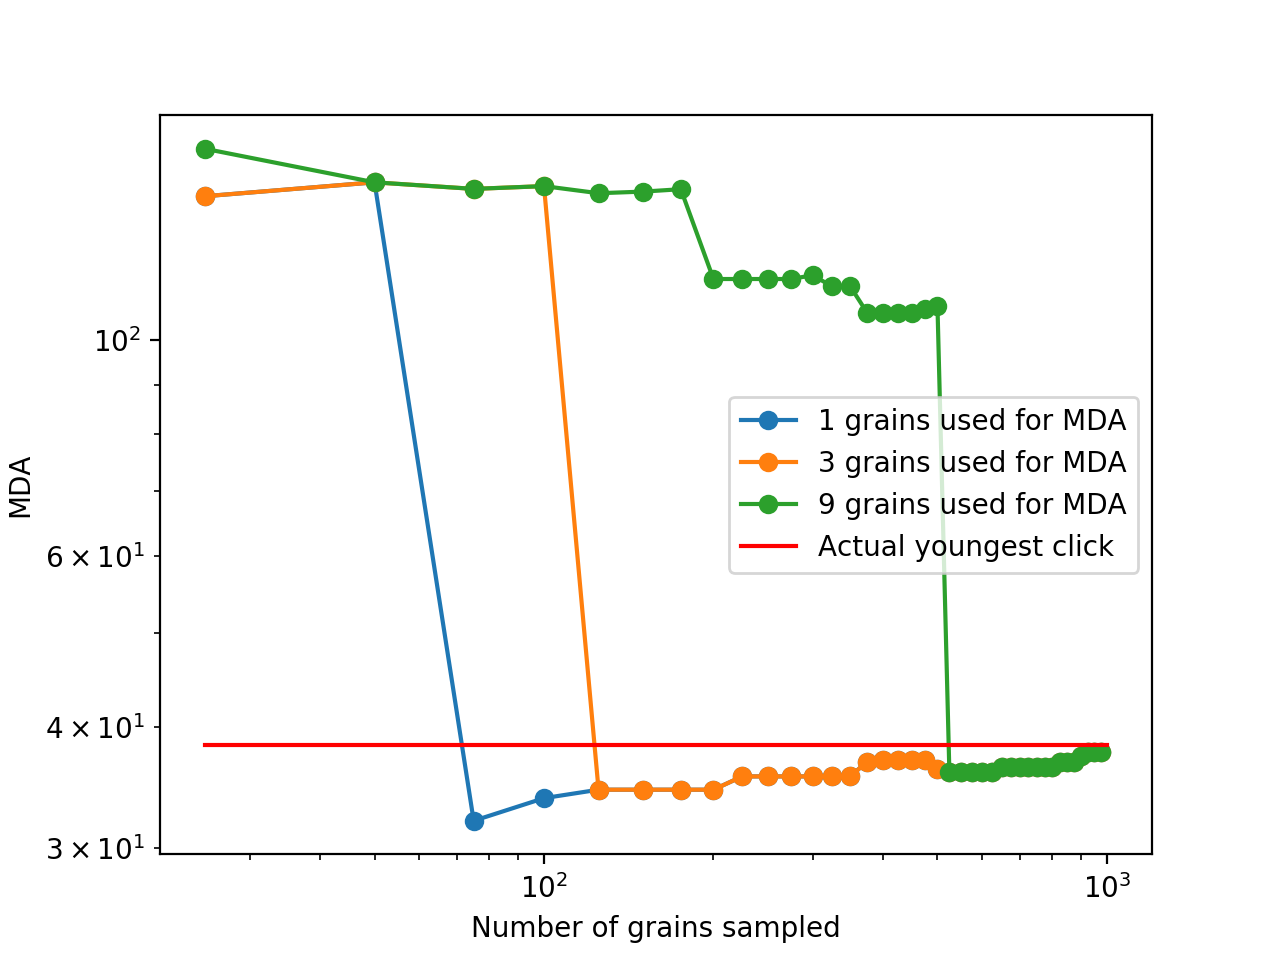

In [13]:
#First how many grains do we want to sample?
minGrainsToSample = 25
maxGrainsToSample = 1000
nSamplingInterval = 25
nGrainsForMDA = [1,3,9]

nsToTest = np.arange(minGrainsToSample,maxGrainsToSample,nSamplingInterval)
#Preallocate for our different scenarios this time
MDAs = np.zeros((len(nGrainsForMDA),len(nsToTest)))

#Start with the minimum number of grains
sampledAges = np.random.choice(ageAxis,minGrainsToSample,replace = True,p = pdp/np.sum(pdp))
sampledErrors = sampledAges*relativeError

#Iterate through our different cases
for j,n in enumerate(nGrainsForMDA):
    MDAs[j,0] = MDA_simpleOverlap(sampledAges,sampledErrors,n = n)[0]

#ITerate through the different number of grains to test
for i in range(1,len(nsToTest)):
    #Select some new grains
    newGrains = np.random.choice(ageAxis,nSamplingInterval,replace = True,p = pdp/np.sum(pdp))
    #Add them to our existing list of grains, and recalculate all the errors
    sampledAges = np.append(sampledAges,newGrains)
    sampledErrors = sampledAges*relativeError
                     
    #Iterate through each of the criteria
    for j,n in enumerate(nGrainsForMDA):
        #Calculate the MDA
        MDAs[j,i] = MDA_simpleOverlap(sampledAges,sampledErrors,n = n)[0]

plt.figure()
#Plot the results
for j,n in enumerate(nGrainsForMDA):
    plt.plot(nsToTest,MDAs[j,:],'-o',label = '{} grains used for MDA'.format(n))
                     
plt.plot([minGrainsToSample,maxGrainsToSample],[TrueMDA,TrueMDA],'-r',label = 'Actual youngest click')
plt.xlabel('Number of grains sampled')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('MDA')
plt.legend()

This can provide us a sense of what can happen given specific cases, but is there a general way to describe this effect? Specifically, how likely are we to actually observe $k$ grains that came from the youngest unit when we date $n$ total grains?

We can address this problem to conceptualize each of our detrital geochronometer dates as representing one of two possible outcomes; a success or a failure. A success occurs when we date a grain from that youngest unit, a failure when we do not. This can be characterized as a Bernoulli trial. Given that the youngest geologic unit contributed a fraction of the total grains deposited in a unit, $f$, the probability of any one date being a 'success' is $f$ and the probability of a 'failure' is $1 - f$. The probability of dating exactly $k$ grains from the youngest unit out of a total of $n$ grains is given by the binomial distribution

$$p(k) = \left(^n_k\right)f^k(1-f)^{n-k}$$.

Here $\left(^n_k\right)$ (read '$n$ choose $k$') is the binomial coefficient, which accounts for the number of ways that $k$ 'successes' and $n-k$ 'failures' could be organized in a series of $n$ dates.

$$\left(^n_k\right) = \frac{n!}{k!(n-k)!}$$

However a more appropriate question for our purposes is how likely are we to undersample our youngest unit? We can consider the odds of not sampling 'enough' young grains to calculate an MDA as the sum of the odds of sampling too few grains. That is, if we decide we need three grains to calculate an MDA, the odds of not dating all three is the sum of the odds of dating only two grains from the youngest units, dating one grain from the youngest unit, and daing no grains from the youngest unit. We can express this more generally as a sum, specifically the failure of dating enough grains for an MDA is given as 1 less the probability of not dating enough.

$$ p(k >= k_c) = 1 - \sum_{i=0}^{k_c - 1} \left(^n_i\right)f^k(1-f)^{n-i}$$

Where $k_c$ is the number of grains deemed necessary for calculating an MDA. Lets take a look at some plots of this now.


<IPython.core.display.Javascript object>


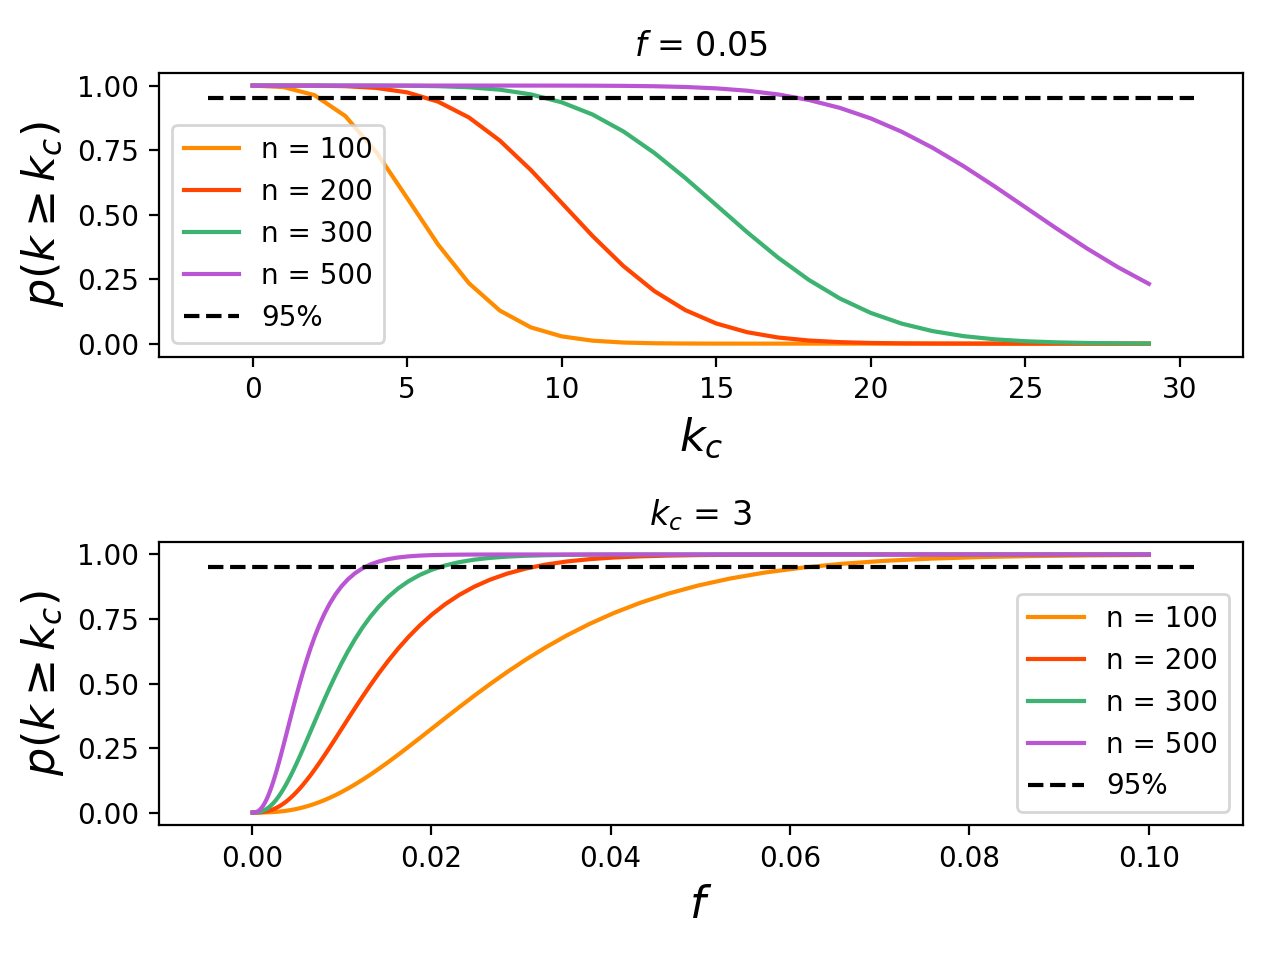

In [14]:
#First lets define the functions we are going to need
from scipy.special import binom #Binomial coefficient
#Calculate the probability of k successes given N trials and a probability of success p
def bernoulliTrial(k,N,p):
    q = 1.0 - p #Probaility of failure
    P = binom(N,k)*(p**k)*(q**(N-k)) #Binomial distribution
    return P

#Calculate the probability of having at least k_c success as 1 less the summed probability of having fewer successes
def atLeastnDrawn(k_c,N,f):
    p = 0.0 #Initalize a zero probability
    
    #Iterate through the options of having to few success to calculate an MDA
    if k_c == 1:
        p+= bernoulliTrial(k_c-1, N,f)
    else:        
        for i in range(int(k_c)):
            p += bernoulliTrial(i,N,f) #Sum the probabilities for each bernoulli trial
    return 1.0 - p #Subtract this probabilty from 1

### Now lets look at what the probability of selecting k_c grains is for different values of k_c
k_csToTest = np.arange(0,30) #Number of youngest grains we want to date
n = [100,200,300,500] #Number of grains
f = 0.05 #Proportion of younest grains in true population distribution
colors = ['darkorange','orangered','mediumseagreen','mediumorchid',]


#Create some subplots
fig, axs = plt.subplots(2,1)

#Loop through each of the options for the number of grains
for i,n_i in enumerate(n):
    thesePs = [atLeastnDrawn(k_c,n_i,f) for k_c in k_csToTest] #Calculate the probabilites for each k_c
    axs[0].plot(k_csToTest,thesePs,'-',color = colors[i],linewidth = 1.5, label = 'n = {:d}'.format(n_i))

axs[0].set_title(r'$f$ = {:.2f}'.format(f))
axs[0].set_xlabel(r'$k_c$',fontsize = 16)
axs[0].set_ylabel(r'$p(k \geq k_c)$',fontsize = 16)
axs[0].plot(axs[0].get_xlim(),[0.95,0.95],'--k',label = '95%')
axs[0].legend(loc = 'best')

#### Not lets look at how this depends on the proportion of the youngest age in the sample
##Define the relevant variables, lets plot a few options
n = [100,200,300,500] #Number of grains
k_c = 3 #how many youngest grains to calculate an MDA
fsToTest = np.logspace(-4,-1,100) #What is the true proportion of youngest grains in the population?

for i,n_i in enumerate(n):
    thesePs = [atLeastnDrawn(k_c,n_i,f_i) for f_i in fsToTest] #Calculate the probabilites for each f
    axs[1].plot(fsToTest,thesePs,'-',color = colors[i],linewidth = 1.5, label = 'n = {:d}'.format(n_i))

axs[1].set_title(r'$k_c$ = {:.0f}'.format(k_c))
axs[1].set_xlabel(r'$f$',fontsize = 16)
axs[1].set_ylabel(r'$p(k \geq k_c)$',fontsize = 16)
axs[1].plot(axs[1].get_xlim(),[0.95,0.95],'--k',label = '95%')
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()

Alternatively, we could look at the joint distributions of probability for different values of $f$ and $n$ for a few different values of $k_c$. After all, it seems like the most common approaches require either 1,2,or 3 grains.

**Be sure to run the above cell first, we will use the same functions**

<IPython.core.display.Javascript object>


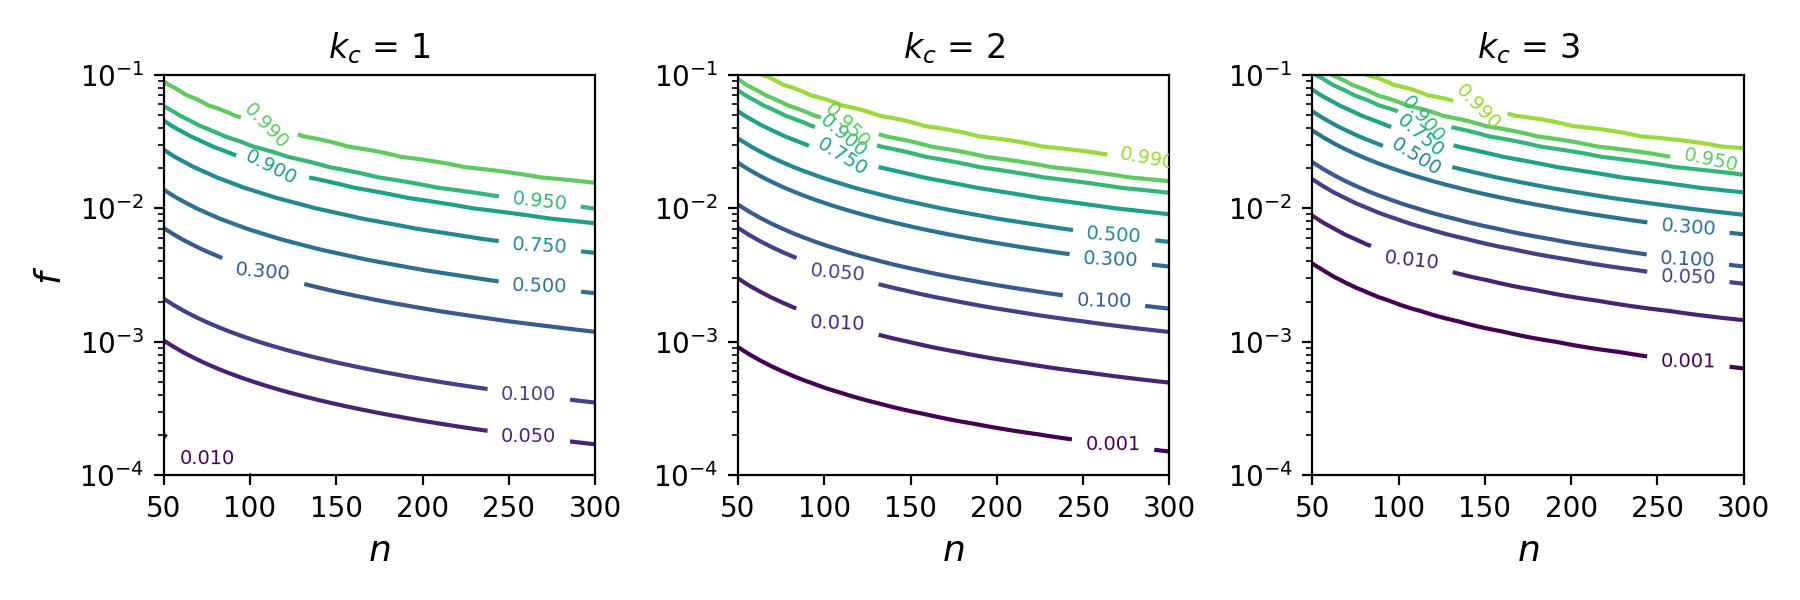

In [15]:
#Which values of k_c do we want to look at subplots for?
kcs = [1,2,3]

ns = np.linspace(50,300,40) #Create an evenly spaced list of the number of grains from 50-500, let there be 50 items
fs = np.logspace(-4, -1,40) #Proportion of youngest grains in true population distribution to test (logspace might be better)

NS,FS = np.meshgrid(ns,fs)

#Create a subplot of these
fig, axs = plt.subplots(1,len(kcs),figsize = (9,3))

psToPlot = [0.001,0.01, 0.05, 0.1, 0.3, 0.5, 0.75, 0.9, 0.95, 0.99]

#Manually specify a colormap (the end of  alot of the perceptually uniform colormaps looks terrible on white)
from matplotlib import cm
cmap = cm.get_cmap('viridis') #Specify a colormap
colors = [cmap(i) for i in np.linspace(0,0.85,len(psToPlot))] #I go from 0 - .85 (as opposed to 1) to not get the saturated colors

#Iterate through the different values of kc
for i,kc in enumerate(kcs):
    
    #Initialize a p matrix
    p = np.zeros_like(FS)
    
    #Iterate through the rows
    for j in range(len(fs)):
        #Iterate through the columns
        for k in range(len(ns)):
            p[j,k] = atLeastnDrawn(kc,NS[j,k],FS[j,k])
    
    CS = axs[i].contour(NS,FS,p,levels = psToPlot,colors = colors)
    axs[i].clabel(CS, inline=1, fontsize=7)
    axs[i].set_title(r'$k_c$ = {}'.format(kc))
    axs[i].set_xlabel(r'$n$',fontsize = 13)
    
    if i == 0: #Only draw y axis label on left
        axs[i].set_ylabel(r'$f$',fontsize = 13)
    else: #Clear the tick labels too
        axs[i].set_yticklabels([])
        
    axs[i].set_yscale('log')
    

plt.tight_layout()
plt.savefig('Bernoulli_NvsF.eps')

Its useful to recast this as a simpler question; How many grains do we need to date to be 95% confident that we date at least 2,3,4 etc of the youngest grains?

In another words, what number of grains do we need such that $p(k >= k_c) = 0.95$?

<IPython.core.display.Javascript object>


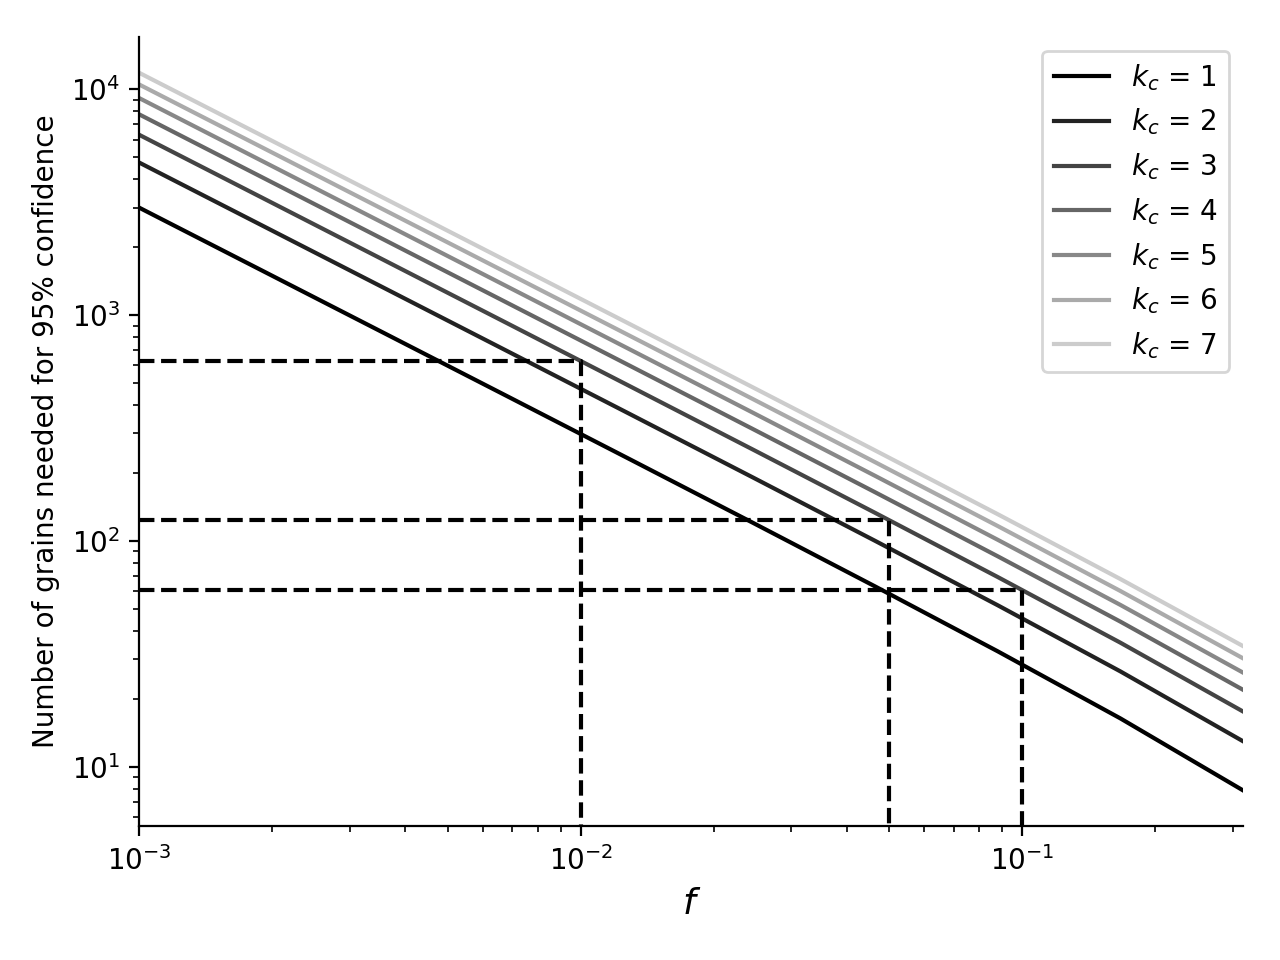

For f = 0.01 you should date 627 grains to be 95.0% sure you captured 3 grains from the youngest component
For f = 0.05 you should date 123 grains to be 95.0% sure you captured 3 grains from the youngest component
For f = 0.1 you should date 60 grains to be 95.0% sure you captured 3 grains from the youngest component


In [16]:
#Lets construct a 'root' finding function - e.g. a function that finds the number of grains necessary such 
# that $p(k>=K_c) = 95%
from scipy.optimize import *
def findNGrains(f,k_c,sigLevel):
    '''
    Compute the number of grains needed, given the input parameters, to achieve some level of confidence
    in having dated 'enough' young grains. 
    
    :param f: proportion of grains from youngest unit
    :param k_c: number of grains needed to date youngest unit
    :param sigLevel: how confident do we need to be that we date k_c grains from the youngest unit
    :return: n: the number of grains needed to reach the asserted significance level
    '''
    # I am making this easy to code by treating it as a 'root finding', optimization problem. How many grains do I need
    # so that the difference between the desired and actual significane level is 0?
    rootFun = lambda n: (sigLevel - atLeastnDrawn(k_c,n,f))
    
    #This is finding and returning the roots between 0 and 1e9 (if f gets reeealy small this will run into problems,
    # but the problems will be smaller than those faced by whoever thinks they want to date 1e9 grains...)
    return brentq(rootFun,0,1e9)

## What parameter space of fs and kcs do we want to search over?
kcs = [1,2,3,4,5,6,7]

fs = np.logspace(-3, -0.5,10) #Proportion of youngest grains in true population distribution to test (logspace might be better)
alpha = 0.95 #Confidence level we want to achieve

fig, ax = plt.subplots(1,1)
cmap = cm.get_cmap('gray')
colors = [cmap(i) for i in np.linspace(0,0.8,len(kcs))]

#Iterate through the different values of kc
for i,kc in enumerate(kcs):
    
    #Initialize a p matrix
    nGrainsNeeded = [findNGrains(f_i,kc,alpha) for f_i in fs]
    
    ax.plot(fs,nGrainsNeeded,'-',color = colors[i],label = r'$k_c$ = {}'.format(kc))

ax.set_xlim(fs[0],fs[-1])
    
#Also plot some special cases, how many grains do you need to be 95% sure you got 3 grains from a sample of 
# where f = some percents

specialK_c = kcs[2]
specialFsToPlot = np.array([0.01, 0.05, 0.10]) #What if youngest component makes of 1%, 5%, 10% of grains?
nGrainsExampleValues = np.array([findNGrains(f_i,specialK_c,alpha) for f_i in specialFsToPlot])

for n,f in zip(nGrainsExampleValues,specialFsToPlot):
    print('For f = {} you should date {} grains to be {}% sure you captured {} grains from the youngest component'.format(
        f, int(n),alpha*100,int(specialK_c)))
    ax.plot([ax.get_xlim()[0], f, f],[n,n,ax.get_ylim()[0]],'--k')

ax.set_ylabel('Number of grains needed for {:.0f}% confidence'.format(alpha*100))
ax.set_xlabel(r'$f$',fontsize = 13)
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(loc = 'upper right')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout()
plt.savefig('NGrainsRequired.eps')

In [17]:
#Attention!
#This is how I used to have the code.... I had an error in here, that I was doing range(k_c - 1),
#forgetting that 'range' already subtracted one from the end of my iteration list

def bernoulliTrial(k,N,p):
    q = 1.0 - p #Probaility of failure
    P = binom(N,k)*(p**k)*(q**(N-k)) #Binomial distribution
    return P

#Calculate the probability of having at least k_c success as 1 less the summed probability of having fewer successes
def atLeastnDrawn(k_c,N,f):
    p = 0.0 #Initalize a zero probability
    
    #Iterate through the options of having to few success to calculate an MDA
    if k_c == 1:
        p+= bernoulliTrial(k_c-1, N,f)
    else:        
        '''This is the error...I wrapped up math notation (summing from 0 to k_c - 1) 
        with python notation (where range already counts to 1 less than the value)'''
        #         for i in range(int(k_c)-1): ...the error
        for i in range(int(k_c)): #This is the correction
            p += bernoulliTrial(i,N,f) #Sum the probabilities for each bernoulli trial
    return 1.0 - p #Subtract this probabilty from 1

atLeastnDrawn(2,100,0.0465)
# atLeastnDrawn(3,100,0.01) #For printing specific test cases

0.9497416279376566

<IPython.core.display.Javascript object>


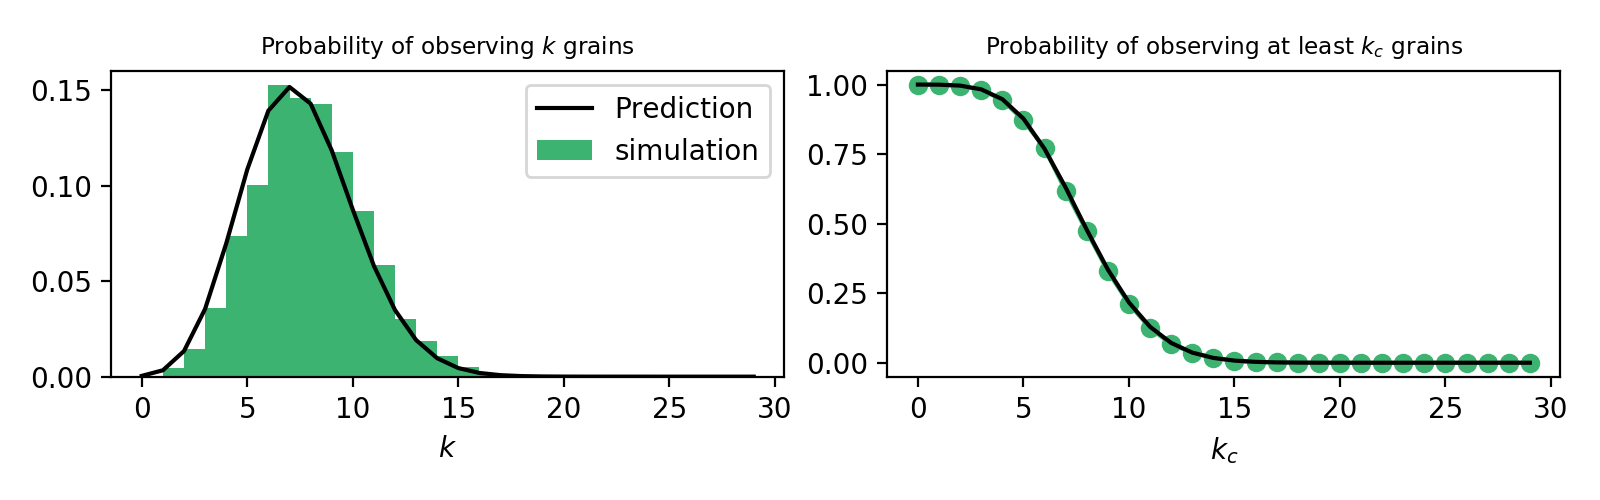

In the simulations, we observed at least 3 grains 98.10%% of cases
The prediction was for 98.29%% of cases


In [18]:
## To confirm everything, we can try a synthetic versions of a binomial experiment
'''We will preform a number of simulated raffles. In each raffle, we will count how many winners there were (e.g., 
how many tickets with values less than or equal to f), then we'll see how common it was to observe different counts.'''

nSims = 5000 #How many simulated raffles do we want to conduct?
f = 0.075 #How common are 'winners' in the raffle? E.g. how frequent are the youngest zircons in this analysis?
nGrains = 100 #How many raffle tickes are issued in each simulation, that is how many grains do we date?
kc = 3 #How many winning tickets (e.g., youngest zircons) do we claim to need to calculate an MDA?

grainsObserved = np.zeros(nSims) #Preallocate space to count raffle winners

#Loop through our simulations
for i in range(nSims):
    values = np.random.uniform(size = nGrains) #Draw a number of raffle tickes with values between 0 and 1 from a uniform distribution
    grainsObserved[i] = np.sum(values <= f) #Those tickes with numbers less than f are our 'winners' (e.g., the grains from the youngest population)

#Prep some plots
fig,axs = plt.subplots(1,2,figsize = [8,2.5])
ks = np.arange(0,30)
#Plot a histogram of the number of winners 
axs[0].hist(grainsObserved,bins = ks,histtype = 'stepfilled',color = 'mediumseagreen',normed = True,label = 'simulation')

#Now calculate this with binomial experiment probability
ps = [bernoulliTrial(k,nGrains,f) for k in ks]
axs[0].plot(ks,ps,'-k',label = 'Prediction')

axs[0].legend()
axs[0].set_title('Probability of observing $k$ grains',fontsize = 'small')
axs[0].set_xlabel('$k$')

print('In the simulations, we observed at least {:.0f} grains {:.2f}%% of cases'.format(kc,100.0*np.sum(grainsObserved>=kc)/nSims))

print('The prediction was for {:.2f}%% of cases'.format(atLeastnDrawn(kc,nGrains,f)*100.0))

#Make a plot for different k_c values
fractionOfTimesObservedEnough = [np.sum(grainsObserved>=k)/nSims for k in ks]
predicted_fraction = [atLeastnDrawn(k,nGrains,f) for k in ks]

axs[1].plot(ks,fractionOfTimesObservedEnough,'-o',color = 'mediumseagreen',label = 'simulation')
axs[1].plot(ks,predicted_fraction,'-k',label = 'Prediction')
axs[1].set_title('Probability of observing at least $k_c$ grains',fontsize = 'small')
axs[1].set_xlabel('$k_c$')

plt.tight_layout()